# Color correction experiment

In [1]:
from exp.nb_Tesis import *


In [2]:
# pip install --upgrade efficientnet-pytorch


In [3]:
urls2019 = ['https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip',
        'https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv']

In [4]:
# for idx,url in enumerate(urls2019):
#   !wget $url

In [5]:
# !unzip ISIC_2019_Training_Input.zip

In [6]:
min_dim = 128# 448

trainImagesFolderName = 'ISIC_2019_Training_Input'
trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'
testImagesFolderName = 'ISIC2018_Task3_Test_Input'
smallTestImagesFolderName = f'small_{min_dim}_ISIC2018_Task3_Test_Input'

trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'


In [7]:
df = pd.read_csv(trainingGroundTruthFileName); print('# of images: ', len(df)); df.head()

# of images:  25331


image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0

In [8]:
dfSingleLabel = pd.DataFrame({'image':df['image'] })
labelcols = df.columns[1:len(df.columns)]
dfSingleLabel['label'] = df[list(labelcols)].idxmax(axis='columns')
dfSingleLabel.head()

image label
0  ISIC_0000000    NV
1  ISIC_0000001    NV
2  ISIC_0000002   MEL
3  ISIC_0000003    NV
4  ISIC_0000004   MEL

In [9]:
#export
labels_for_2018_live_challenge = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image']==image_name].label)[0]
  
def get_label_for_image_path(image_path): return get_label_for_image_name(image_path.name[:-4])

#### Prune the dataset if needed

In [10]:
labels_exclusive_for_2019 = ['SCC']
training_for_2018 = True
max_of_each = 30
classDict = {}
images = get_image_files(trainImagesFolderName)
newFolder = f'picked_{max_of_each}_{trainImagesFolderName}'
destFolder = Path(newFolder)
destFolder.mkdir(parents=True, exist_ok=True);

def prune_dataset(image,idx):
    label = get_label_for_image_path(image)
    if training_for_2018 and label in labels_exclusive_for_2019: return
    if label in classDict: classDict[label] = classDict[label] + 1
    else: classDict[label] = 1
    if classDict[label] < max_of_each:
        !cp './'$image $destFolder'/'
#         print(classDict[label],max_of_each)

# parallel(partial(prune_dataset),images)
    

#### Remove warnings

In [11]:
!nvidia-smi

Sun Mar  8 13:34:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
| 24%   35C    P8    16W / 250W |     12MiB / 11176MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [13]:
# torch.cuda.set_device(0)

## Load the dataset

In [14]:
destFolder

PosixPath('picked_30_ISIC_2019_Training_Input')

In [15]:
def reload_dataset(imgs_folder):
    random_seed(1,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.8, max_lighting=.3,p_affine=1, max_warp=0)

    data = ImageList.from_folder(imgs_folder)\
    .split_by_rand_pct()\
    .label_from_func(get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize()
    return data

data = reload_dataset(destFolder)

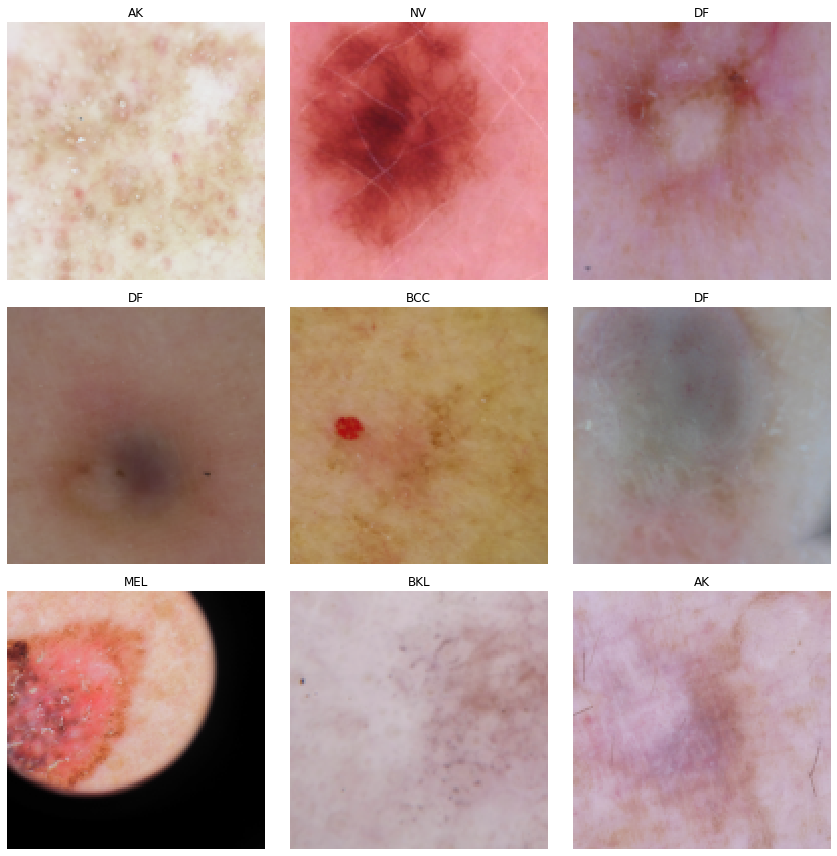

In [16]:
data.show_batch(3)

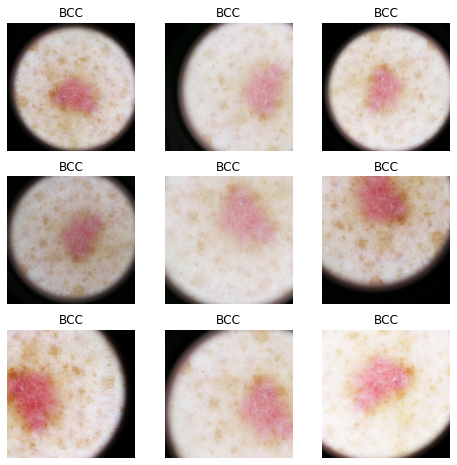

In [17]:
def _plot(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [18]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 BCC     381
MEL     374
NV      366
BKL     363
AK      362
VASC    203
DF      201
dtype: int64 

 valid_count: 
 AK      102
BKL     101
NV       98
MEL      90
BCC      83
VASC     50
DF       38
dtype: int64
ratios:
AK      0.281768
BCC     0.217848
BKL     0.278237
DF      0.189055
MEL     0.240642
NV      0.267760
VASC    0.246305
dtype: float64 %


In [50]:
#export

# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

def get_class_weights(data):
    train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
    train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

    weighted_classes = [{c: (sum(train_count) / train_count[c] * len(data.classes))} for c in data.classes];
    print(weighted_classes)
    formatted_weights = [w[c] for c,w in zip(data.classes, weighted_classes) ]
    class_weights=torch.FloatTensor(formatted_weights).cuda()
    class_weights = class_weights / sum(class_weights)
    return class_weights

def train_learner(learner, name, epochs=8, lr=1e-3, wd = 1e-4, balanced=True,seed=1):
    if balanced: learner.loss_func = CrossEntropyFlat(weight = get_class_weights(learner.data))
    random_seed(seed,True)
    log_name = f'2019_imgsz_{learner.data.valid_ds[0][0].shape[1]}_{name}'
    print("Saving log on: ",log_name)
    learner.fit_one_cycle(epochs,max_lr=lr,wd=wd
                          ,callbacks = [
                            SaveModelCallback(learn=learner,name=log_name,monitor='accuracy'),
                            CSVLogger(learn=learner,filename=log_name),
                            ]
                         )

## Color correction

In [43]:
def max_rgb(image):
  # First get the maximum across the rows, then take the values and take the maximum again (this time dimension 1 will be the columns)
  return image.max(dim=1)[0].max(dim=1)[0]
  
def computeGrayWorldOnChannel(image, channel,p):
    I_cx = image[channel].sum()
    img_size = image[channel].shape.numel()
    return ( (I_cx ** p) / img_size )  ** (1/p) 

def shades_of_gray(img, p):
    n_channels, height, width  = img.shape
    iluminant = torch.zeros(3)
    for channel in range(n_channels):
        iluminant[channel] = computeGrayWorldOnChannel(img,channel,p)
    return iluminant

In [44]:
def correct_iluminant(estimated_iluminant):
    gamma = (torch.ones(3) / math.sqrt(3))
    corrected_iluminant = gamma * (1 / estimated_iluminant)
    return corrected_iluminant

def correct_image(image,estimated_iluminant):
    corrected_iluminant = correct_iluminant(estimated_iluminant)
    mat_iluminant = corrected_iluminant[:,None,None].expand(image.shape)
    c = mat_iluminant * image
    return c

In [45]:
def _correct_color_max_rgb(image):
    estimated_iluminant = max_rgb(image);

    c = correct_image(image,estimated_iluminant)
    return c

def _correct_color_shades_of_gray(image):
    estimated_iluminant = shades_of_gray(image,1);

    c = correct_image(image,estimated_iluminant)
    return torch.clamp(c,0,1)

correct_color_max_rgb = TfmPixel(_correct_color_max_rgb)
correct_color_shades_of_gray = TfmPixel(_correct_color_shades_of_gray)

### Testing Visualization

#### Max RGB

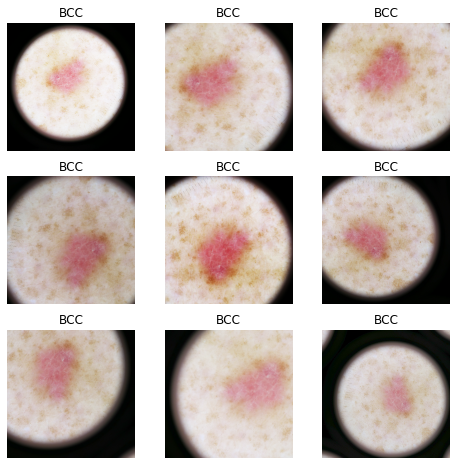

In [23]:
data = reload_dataset(destFolder)
plot_multi(_plot, 3, 3, figsize=(8,8))

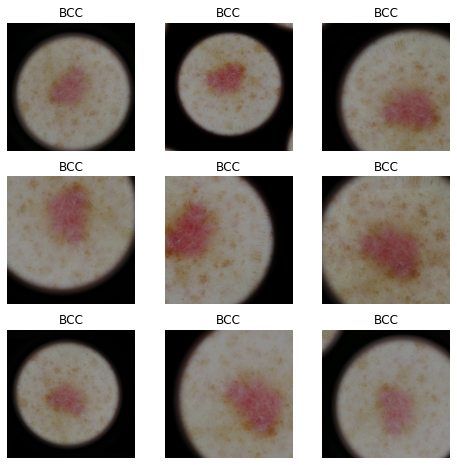

In [24]:
data.train_ds.tfms.insert(0,correct_color_max_rgb());
plot_multi(_plot, 3, 3, figsize=(8,8))

#### Shades of gray

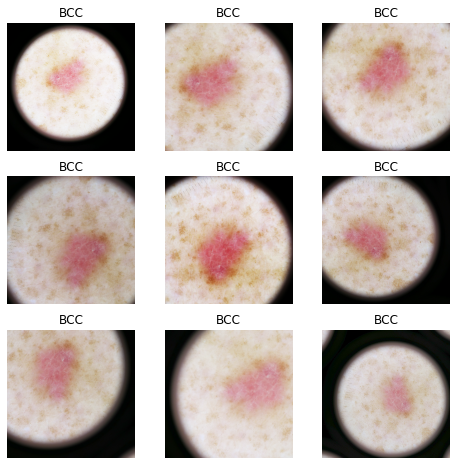

In [25]:
data = reload_dataset(destFolder)
plot_multi(_plot, 3, 3, figsize=(8,8))

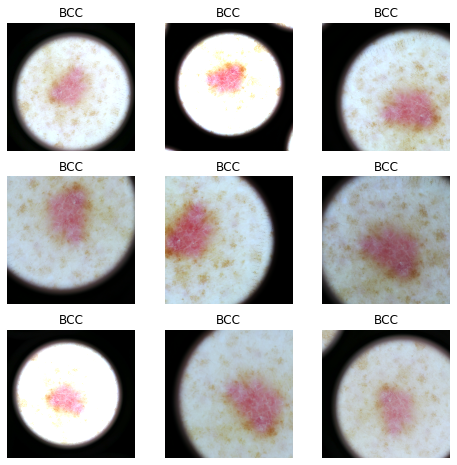

In [26]:
data.train_ds.tfms.insert(0,correct_color_shades_of_gray());
plot_multi(_plot, 3, 3, figsize=(8,8))

# Training

First let's see the baseline result
* Images prerezised to: 128px

* get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=.3,p_affine=1, max_warp=0)
* batch_size = 16
* random_seed 1
* epochs = 8 
* one_cycle_policy, max_lr = 1e-3, wd 1e-4
* balancing per class: True
* pretrained = True
* unfreezed = True
* Efficientnet-b0

train_count: 
 BKL     313
NV      311
AK      305
MEL     300
BCC     297
SCC     278
VASC    196
DF      192
dtype: int64 

 valid_count: 
 BCC     80
AK      80
MEL     78
SCC     70
BKL     69
NV      66
VASC    57
DF      47
dtype: int64

### Without color correction

In [46]:
images_folder = 'picked_30_ISIC_2019_Training_Input'
data = reload_dataset(images_folder)

In [47]:
from efficientnet_pytorch import EfficientNet

random_seed(1,True)

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0 = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
#                             ActivationStats,
                                ])

# learn_b0.summary()

Loaded pretrained weights for efficientnet-b0


[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


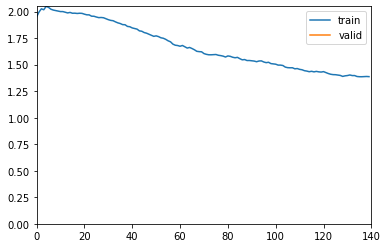

Better model found at epoch 0 with accuracy value: 0.5213522911071777.


In [48]:
train_learner(learn_b0,'EfficientNet-b0')

## With color correction

### Max RGB

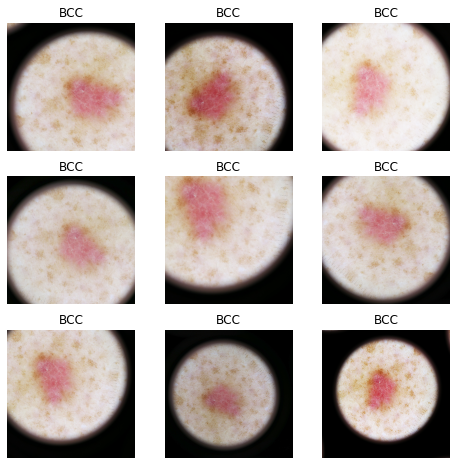

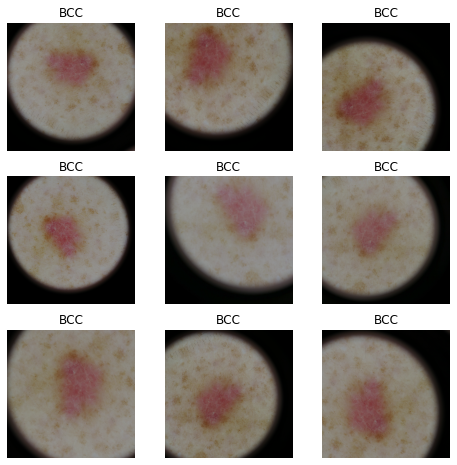

In [31]:
data = reload_dataset(destFolder)
plot_multi(_plot, 3, 3, figsize=(8,8))

# Insertamos en train como en valid ds, la correcion de color Max rgb en la primer posicion
data.train_ds.tfms.insert(0,correct_color_max_rgb());
data.valid_ds.tfms.insert(0,correct_color_max_rgb());
plot_multi(_plot, 3, 3, figsize=(8,8))

In [32]:
from efficientnet_pytorch import EfficientNet

random_seed(1,True)

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0_max_rgb = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                ])

# learn_b0.summary()

Loaded pretrained weights for efficientnet-b0


In [39]:
len(learn_b0_max_rgb.data.train_dl)

17

[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


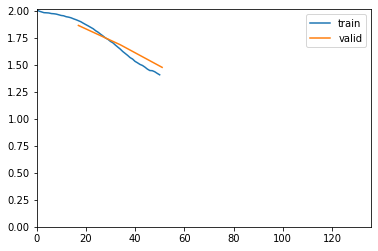

Better model found at epoch 0 with accuracy value: 0.24911032617092133.
Better model found at epoch 1 with accuracy value: 0.4056939482688904.
Better model found at epoch 2 with accuracy value: 0.4555160105228424.


RuntimeError: Could not infer dtype of NoneType

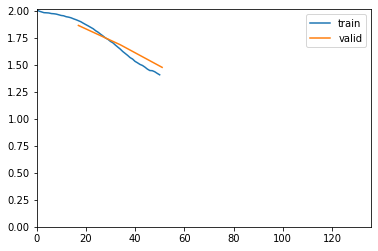

In [33]:
train_learner(learn_b0_max_rgb,'EfficientNet-b0')

### Shades of Gray

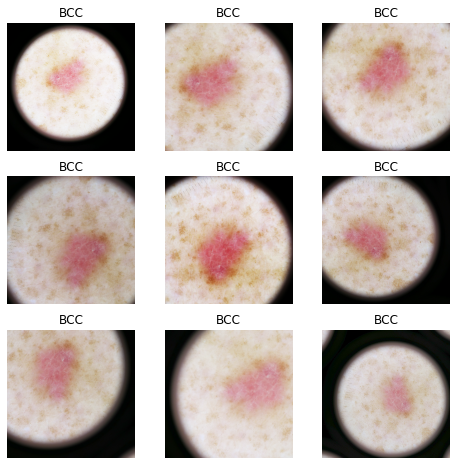

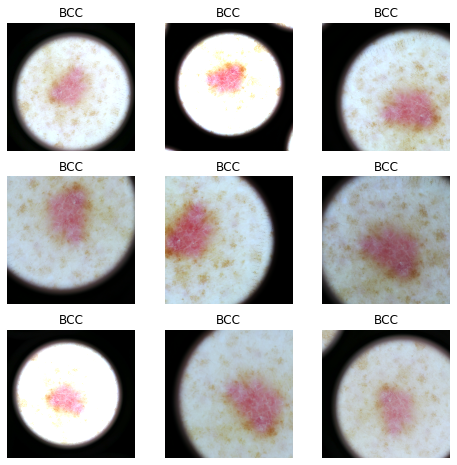

In [56]:
data = reload_dataset(destFolder)
plot_multi(_plot, 3, 3, figsize=(8,8))

# Insertamos en train como en valid ds, la correcion de color Max rgb en la primer posicion
data.train_ds.tfms.insert(0,correct_color_shades_of_gray());
data.valid_ds.tfms.insert(0,correct_color_shades_of_gray());
plot_multi(_plot, 3, 3, figsize=(8,8))

In [39]:
from efficientnet_pytorch import EfficientNet

random_seed(1,True)

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0_shades_of_gray = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                ])

# learn_b0.summary()

Loaded pretrained weights for efficientnet-b0


[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


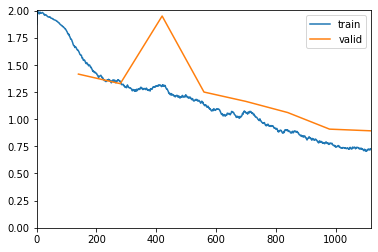

Better model found at epoch 0 with accuracy value: 0.47330960631370544.
Better model found at epoch 1 with accuracy value: 0.4750889539718628.
Better model found at epoch 3 with accuracy value: 0.5533807873725891.
Better model found at epoch 5 with accuracy value: 0.5889679789543152.
Better model found at epoch 6 with accuracy value: 0.6441280841827393.


RuntimeError: Could not infer dtype of NoneType

In [40]:
train_learner(learn_b0_shades_of_gray,'EfficientNet-b0')

### Shades of gray más tranqui

In [61]:
def _correct_color_shades_of_gray(image):
    estimated_iluminant = shades_of_gray(image,1.05);

    c = correct_image(image,estimated_iluminant)
    return torch.clamp(c,0,1)

correct_color_shades_of_gray = TfmPixel(_correct_color_shades_of_gray)

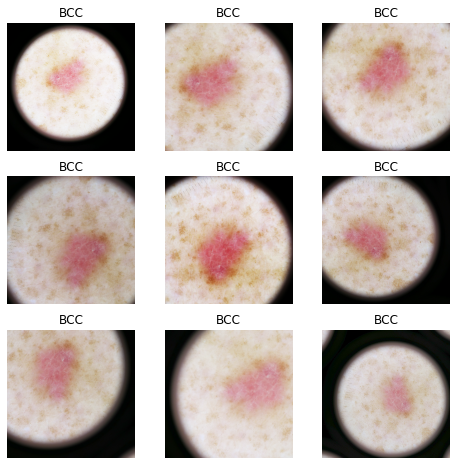

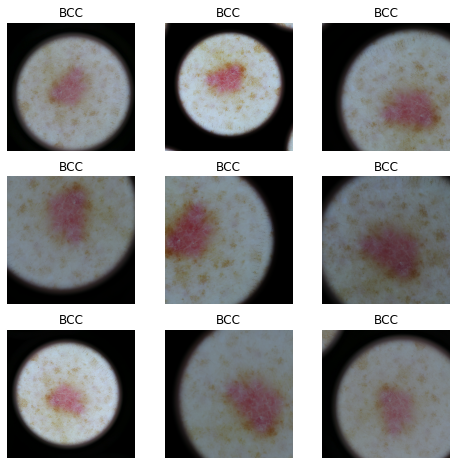

In [62]:
data = reload_dataset(destFolder)
plot_multi(_plot, 3, 3, figsize=(8,8))

# Insertamos en train como en valid ds, la correcion de color Max rgb en la primer posicion
data.train_ds.tfms.insert(0,correct_color_shades_of_gray());
data.valid_ds.tfms.insert(0,correct_color_shades_of_gray());
plot_multi(_plot, 3, 3, figsize=(8,8))

In [63]:
from efficientnet_pytorch import EfficientNet

random_seed(1,True)

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0_shades_of_gray_2 = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                ])

# learn_b0.summary()

Loaded pretrained weights for efficientnet-b0


[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


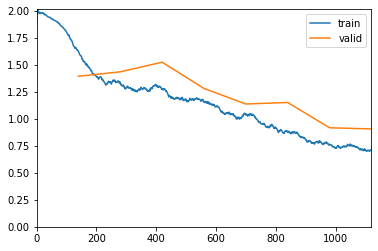

Better model found at epoch 0 with accuracy value: 0.4715302586555481.
Better model found at epoch 2 with accuracy value: 0.48932385444641113.
Better model found at epoch 3 with accuracy value: 0.5035586953163147.
Better model found at epoch 4 with accuracy value: 0.5373665690422058.
Better model found at epoch 5 with accuracy value: 0.5480427145957947.
Better model found at epoch 6 with accuracy value: 0.6156583428382874.
Better model found at epoch 7 with accuracy value: 0.6370106935501099.


RuntimeError: Could not infer dtype of NoneType

In [64]:
train_learner(learn_b0_shades_of_gray_2,'EfficientNet-b0')

# Iterations

In [101]:
f= open("run_seed_1.txt","w+")


In [102]:
f.write('Max_RGB, Without Color Correction \n')

35

In [104]:
f.close()

In [105]:
f= open("run_seed_1.txt","r")

In [106]:
f.read()

'Max_RGB, Without Color Correction \n0.46085408329963684,0.46085408329963684\n0.48220640420913696,0.48220640420913696\n0.5071174502372742,0.5071174502372742\n0.47686833143234253,0.47686833143234253\n0.6014235019683838,0.6014235019683838\n0.5978647470474243,0.5978647470474243\n0.6405693888664246,0.6405693888664246\n0.6530249118804932,0.6530249118804932\n'

In [91]:
l1 = list(map(lambda x: x[1], learn_b0.recorder.metrics))
l2 = list(map(lambda x: x[1], learn_b0.recorder.metrics))

In [99]:
run = ''.join(map(str,[f'{a.item()},{b.item()}\n' for a,b in zip(l1,l2) ]))


In [103]:
f.write(run)

310

Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


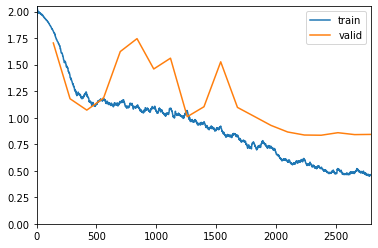

Better model found at epoch 0 with accuracy value: 0.3896797299385071.
Better model found at epoch 1 with accuracy value: 0.5604982376098633.
Better model found at epoch 2 with accuracy value: 0.5747330784797668.
Better model found at epoch 8 with accuracy value: 0.6174377202987671.
Better model found at epoch 13 with accuracy value: 0.6494662165641785.
Better model found at epoch 14 with accuracy value: 0.6583629846572876.
Better model found at epoch 15 with accuracy value: 0.6743772029876709.
Better model found at epoch 16 with accuracy value: 0.6992882490158081.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


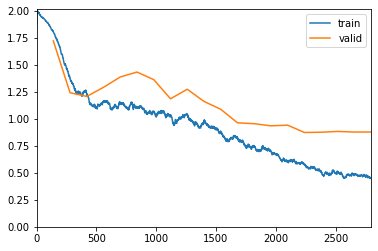

Better model found at epoch 0 with accuracy value: 0.3701067566871643.
Better model found at epoch 1 with accuracy value: 0.5195729732513428.
Better model found at epoch 3 with accuracy value: 0.5604982376098633.
Better model found at epoch 9 with accuracy value: 0.599644124507904.
Better model found at epoch 10 with accuracy value: 0.6049821972846985.
Better model found at epoch 11 with accuracy value: 0.6227757930755615.
Better model found at epoch 12 with accuracy value: 0.6405693888664246.
Better model found at epoch 13 with accuracy value: 0.6654804348945618.
Better model found at epoch 14 with accuracy value: 0.6761565804481506.
Better model found at epoch 15 with accuracy value: 0.6886121034622192.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet

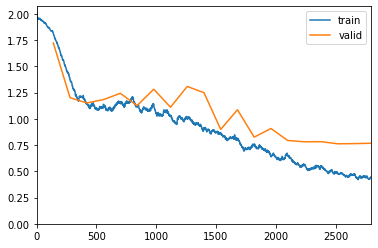

Better model found at epoch 0 with accuracy value: 0.38612100481987.
Better model found at epoch 1 with accuracy value: 0.5604982376098633.
Better model found at epoch 5 with accuracy value: 0.6049821972846985.
Better model found at epoch 10 with accuracy value: 0.6690391302108765.
Better model found at epoch 12 with accuracy value: 0.6992882490158081.
Better model found at epoch 16 with accuracy value: 0.7064056992530823.
Better model found at epoch 17 with accuracy value: 0.7117437720298767.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


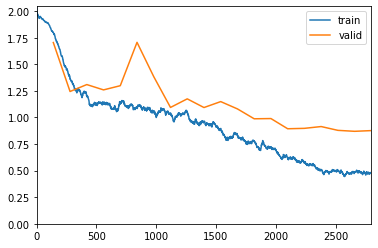

Better model found at epoch 0 with accuracy value: 0.38612100481987.
Better model found at epoch 1 with accuracy value: 0.5195729732513428.
Better model found at epoch 3 with accuracy value: 0.5373665690422058.
Better model found at epoch 6 with accuracy value: 0.5587188601493835.
Better model found at epoch 7 with accuracy value: 0.5604982376098633.
Better model found at epoch 8 with accuracy value: 0.5622775554656982.
Better model found at epoch 9 with accuracy value: 0.6032028198242188.
Better model found at epoch 12 with accuracy value: 0.6156583428382874.
Better model found at epoch 13 with accuracy value: 0.6494662165641785.
Better model found at epoch 14 with accuracy value: 0.6725978851318359.
Better model found at epoch 15 with accuracy value: 0.6886121034622192.
Better model found at epoch 16 with accuracy value: 0.690391480922699.
Better model found at epoch 17 with accuracy value: 0.708185076713562.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {

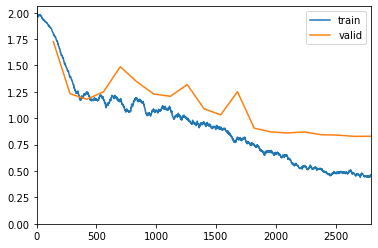

Better model found at epoch 0 with accuracy value: 0.40391460061073303.
Better model found at epoch 1 with accuracy value: 0.5355871915817261.
Better model found at epoch 3 with accuracy value: 0.5373665690422058.
Better model found at epoch 7 with accuracy value: 0.5800711512565613.
Better model found at epoch 9 with accuracy value: 0.626334547996521.
Better model found at epoch 12 with accuracy value: 0.6619216799736023.
Better model found at epoch 14 with accuracy value: 0.6797152757644653.
Better model found at epoch 15 with accuracy value: 0.6868327260017395.
Better model found at epoch 16 with accuracy value: 0.6992882490158081.
Better model found at epoch 17 with accuracy value: 0.708185076713562.
Better model found at epoch 19 with accuracy value: 0.709964394569397.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'

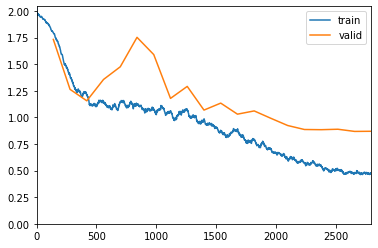

Better model found at epoch 0 with accuracy value: 0.38078293204307556.
Better model found at epoch 1 with accuracy value: 0.5284697413444519.
Better model found at epoch 2 with accuracy value: 0.5551601648330688.
Better model found at epoch 7 with accuracy value: 0.5622775554656982.
Better model found at epoch 9 with accuracy value: 0.6049821972846985.
Better model found at epoch 10 with accuracy value: 0.6103202700614929.
Better model found at epoch 12 with accuracy value: 0.6138790249824524.
Better model found at epoch 13 with accuracy value: 0.645907461643219.
Better model found at epoch 14 with accuracy value: 0.6530249118804932.
Better model found at epoch 15 with accuracy value: 0.690391480922699.
Better model found at epoch 18 with accuracy value: 0.6939501762390137.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {

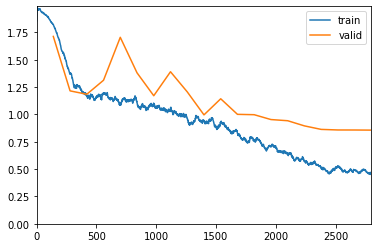

Better model found at epoch 0 with accuracy value: 0.4145907461643219.
Better model found at epoch 1 with accuracy value: 0.5409252643585205.
Better model found at epoch 2 with accuracy value: 0.5569394826889038.
Better model found at epoch 9 with accuracy value: 0.6156583428382874.
Better model found at epoch 11 with accuracy value: 0.6245551705360413.
Better model found at epoch 12 with accuracy value: 0.628113865852356.
Better model found at epoch 13 with accuracy value: 0.6352313160896301.
Better model found at epoch 14 with accuracy value: 0.6494662165641785.
Better model found at epoch 15 with accuracy value: 0.6761565804481506.
Better model found at epoch 17 with accuracy value: 0.6886121034622192.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet

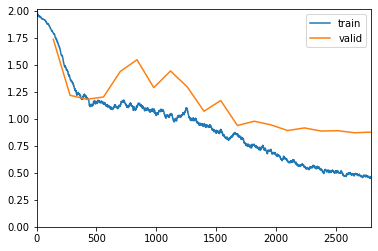

Better model found at epoch 0 with accuracy value: 0.37188613414764404.
Better model found at epoch 1 with accuracy value: 0.5053380727767944.
Better model found at epoch 2 with accuracy value: 0.5533807873725891.
Better model found at epoch 3 with accuracy value: 0.5676156878471375.
Better model found at epoch 9 with accuracy value: 0.6014235019683838.
Better model found at epoch 11 with accuracy value: 0.6245551705360413.
Better model found at epoch 13 with accuracy value: 0.6672598123550415.
Better model found at epoch 14 with accuracy value: 0.6797152757644653.
Better model found at epoch 16 with accuracy value: 0.6832740306854248.
Better model found at epoch 17 with accuracy value: 0.7010676264762878.
Better model found at epoch 18 with accuracy value: 0.7206405401229858.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459},

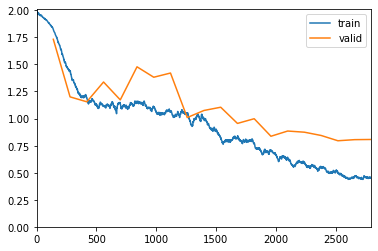

Better model found at epoch 0 with accuracy value: 0.38078293204307556.
Better model found at epoch 1 with accuracy value: 0.5391458868980408.
Better model found at epoch 2 with accuracy value: 0.5587188601493835.
Better model found at epoch 3 with accuracy value: 0.5765124559402466.
Better model found at epoch 8 with accuracy value: 0.626334547996521.
Better model found at epoch 11 with accuracy value: 0.6743772029876709.
Better model found at epoch 13 with accuracy value: 0.6814946532249451.
Better model found at epoch 16 with accuracy value: 0.6850534081459045.
Better model found at epoch 17 with accuracy value: 0.6921707987785339.
Better model found at epoch 18 with accuracy value: 0.7046263217926025.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet

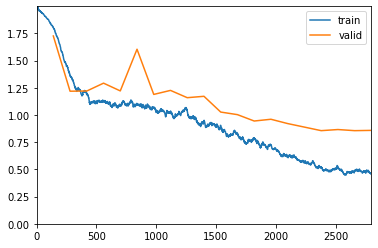

Better model found at epoch 0 with accuracy value: 0.38078293204307556.
Better model found at epoch 1 with accuracy value: 0.5302491188049316.
Better model found at epoch 3 with accuracy value: 0.5533807873725891.
Better model found at epoch 6 with accuracy value: 0.5622775554656982.
Better model found at epoch 7 with accuracy value: 0.5836299061775208.
Better model found at epoch 9 with accuracy value: 0.5907473564147949.
Better model found at epoch 10 with accuracy value: 0.6156583428382874.
Better model found at epoch 11 with accuracy value: 0.628113865852356.
Better model found at epoch 12 with accuracy value: 0.6387900114059448.
Better model found at epoch 13 with accuracy value: 0.6476868391036987.
Better model found at epoch 14 with accuracy value: 0.6797152757644653.
Better model found at epoch 15 with accuracy value: 0.6992882490158081.
Better model found at epoch 16 with accuracy value: 0.7028470039367676.
Better model found at epoch 17 with accuracy value: 0.7135231494903564

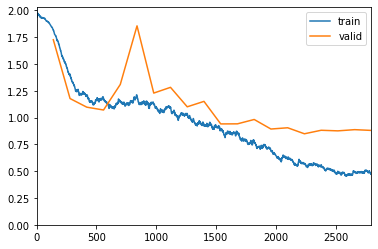

Better model found at epoch 0 with accuracy value: 0.3487544357776642.
Better model found at epoch 1 with accuracy value: 0.5516014099121094.
Better model found at epoch 2 with accuracy value: 0.5533807873725891.
Better model found at epoch 3 with accuracy value: 0.6014235019683838.
Better model found at epoch 9 with accuracy value: 0.6156583428382874.
Better model found at epoch 10 with accuracy value: 0.6298932433128357.
Better model found at epoch 11 with accuracy value: 0.6476868391036987.
Better model found at epoch 13 with accuracy value: 0.6654804348945618.
Better model found at epoch 14 with accuracy value: 0.6725978851318359.
Better model found at epoch 15 with accuracy value: 0.6850534081459045.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet

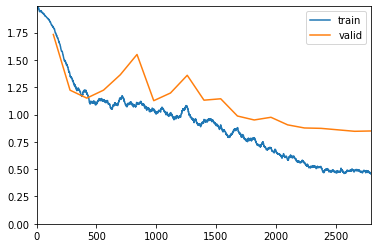

Better model found at epoch 0 with accuracy value: 0.34341636300086975.
Better model found at epoch 1 with accuracy value: 0.5284697413444519.
Better model found at epoch 2 with accuracy value: 0.5622775554656982.
Better model found at epoch 9 with accuracy value: 0.5978647470474243.
Better model found at epoch 11 with accuracy value: 0.628113865852356.
Better model found at epoch 12 with accuracy value: 0.6476868391036987.
Better model found at epoch 13 with accuracy value: 0.6548042893409729.
Better model found at epoch 14 with accuracy value: 0.6779359579086304.
Better model found at epoch 15 with accuracy value: 0.6832740306854248.
Better model found at epoch 16 with accuracy value: 0.6850534081459045.
Better model found at epoch 17 with accuracy value: 0.6868327260017395.
Better model found at epoch 18 with accuracy value: 0.690391480922699.
Better model found at epoch 19 with accuracy value: 0.6975088715553284.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.508287292817

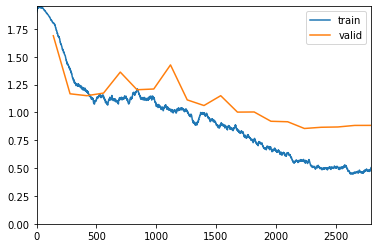

Better model found at epoch 0 with accuracy value: 0.3790035545825958.
Better model found at epoch 1 with accuracy value: 0.5462633371353149.
Better model found at epoch 2 with accuracy value: 0.564056932926178.
Better model found at epoch 3 with accuracy value: 0.5658363103866577.
Better model found at epoch 8 with accuracy value: 0.5676156878471375.
Better model found at epoch 9 with accuracy value: 0.6103202700614929.
Better model found at epoch 11 with accuracy value: 0.6476868391036987.
Better model found at epoch 13 with accuracy value: 0.6921707987785339.
Better model found at epoch 15 with accuracy value: 0.7028470039367676.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


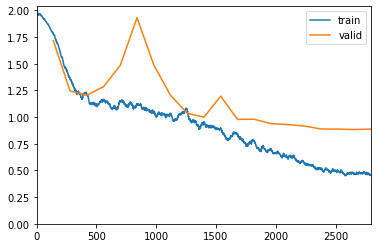

Better model found at epoch 0 with accuracy value: 0.37544482946395874.
Better model found at epoch 1 with accuracy value: 0.5195729732513428.
Better model found at epoch 2 with accuracy value: 0.5284697413444519.
Better model found at epoch 6 with accuracy value: 0.5355871915817261.
Better model found at epoch 7 with accuracy value: 0.5711743831634521.
Better model found at epoch 8 with accuracy value: 0.6156583428382874.
Better model found at epoch 9 with accuracy value: 0.628113865852356.
Better model found at epoch 12 with accuracy value: 0.6387900114059448.
Better model found at epoch 13 with accuracy value: 0.6779359579086304.
Better model found at epoch 15 with accuracy value: 0.6886121034622192.
Better model found at epoch 16 with accuracy value: 0.6957295536994934.
Better model found at epoch 17 with accuracy value: 0.7046263217926025.
Better model found at epoch 18 with accuracy value: 0.7064056992530823.
Better model found at epoch 19 with accuracy value: 0.709964394569397.


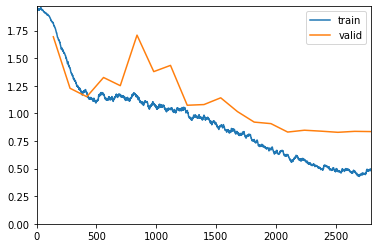

Better model found at epoch 0 with accuracy value: 0.3772242069244385.
Better model found at epoch 1 with accuracy value: 0.5213522911071777.
Better model found at epoch 2 with accuracy value: 0.5409252643585205.
Better model found at epoch 4 with accuracy value: 0.564056932926178.
Better model found at epoch 8 with accuracy value: 0.5889679789543152.
Better model found at epoch 9 with accuracy value: 0.6192170977592468.
Better model found at epoch 12 with accuracy value: 0.6298932433128357.
Better model found at epoch 13 with accuracy value: 0.6672598123550415.
Better model found at epoch 16 with accuracy value: 0.6725978851318359.
Better model found at epoch 17 with accuracy value: 0.6814946532249451.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b

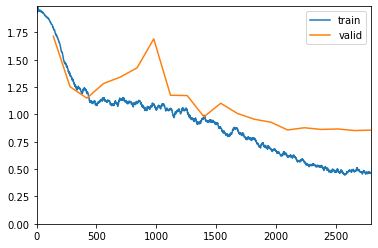

Better model found at epoch 0 with accuracy value: 0.3629893362522125.
Better model found at epoch 1 with accuracy value: 0.5302491188049316.
Better model found at epoch 2 with accuracy value: 0.5498220920562744.
Better model found at epoch 7 with accuracy value: 0.5658363103866577.
Better model found at epoch 8 with accuracy value: 0.5676156878471375.
Better model found at epoch 9 with accuracy value: 0.6334519386291504.
Better model found at epoch 11 with accuracy value: 0.6352313160896301.
Better model found at epoch 13 with accuracy value: 0.6619216799736023.
Better model found at epoch 14 with accuracy value: 0.6868327260017395.
Better model found at epoch 17 with accuracy value: 0.6957295536994934.


In [54]:
from efficientnet_pytorch import EfficientNet
seeds = [1,2,3,4,5,6,7,8]
epochs = 20
images_folder = 'picked_30_ISIC_2019_Training_Input'

for s in seeds:
    data = reload_dataset(images_folder)
    random_seed(s,True)

    model_name = 'efficientnet-b0'
    model_b0 = EfficientNet.from_pretrained(model_name)
    model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

    learn_b0 = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph
                                ])

    # learn_b0.summary()


    train_learner(learn_b0,'EfficientNet-b0',epochs=epochs, seed=s)
    l1 = list(map(lambda x: x[1], learn_b0.recorder.metrics))
    
    
    
    
    #Con color correction
    
    
    data = reload_dataset(destFolder)

    # Insertamos en train como en valid ds, la correcion de color Max rgb en la primer posicion
    data.train_ds.tfms.insert(0,correct_color_max_rgb());
    data.valid_ds.tfms.insert(0,correct_color_max_rgb());

    random_seed(s,True)

    model_name = 'efficientnet-b0'
    model_b0 = EfficientNet.from_pretrained(model_name)
    model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

    learn_b0_max_rgb = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph
                                ])

    # learn_b0.summary()
    train_learner(learn_b0_max_rgb,'EfficientNet-b0',epochs=epochs, seed=1)
    
    l2 = list(map(lambda x: x[1], learn_b0_max_rgb.recorder.metrics))
    
    f = open(f'run_seed_{s}.txt','w+')
    f.write('Without Color Correction, Max_RGB\n')
    run = ''.join(map(str,[f'{a.item()},{b.item()}\n' for a,b in zip(l1,l2) ]))
    f.write(run)
    f.close()